In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
from pyspark.sql import functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.decomposition import PCA

/home/acmiy/birdclef-2023/venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from birdclef.utils import get_spark

spark = get_spark(memory="2g")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/05 04:35:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df = spark.read.parquet(
    "../data/processed/birdclef-2022/birdnet-embeddings-with-neighbors/v1"
)
df.printSchema()
df.show(n=1, vertical=True)

root
 |-- id: integer (nullable = true)
 |-- filename: string (nullable = true)
 |-- start_sec: double (nullable = true)
 |-- end_sec: double (nullable = true)
 |-- confidence: double (nullable = true)
 |-- birdnet_label: string (nullable = true)
 |-- birdnet_common_name: string (nullable = true)
 |-- emb: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- primary_label: string (nullable = true)
 |-- secondary_labels: string (nullable = true)
 |-- type: string (nullable = true)
 |-- neighbors: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- distances: array (nullable = true)
 |    |-- element: double (containsNull = true)



-RECORD 0-----------------------------------
 id                  | 11876                
 filename            | belkin1/XC321817.ogg 
 start_sec           | 15.0                 
 end_sec             | 18.0                 
 confidence          | 0.1058               
 birdnet_label       | rucspa               
 birdnet_common_name | Rufous-crowned Sp... 
 emb                 | [0.54678416, 0.58... 
 primary_label       | belkin1              
 secondary_labels    | []                   
 type                | ['song']             
 neighbors           | [11877, 11876, 11... 
 distances           | [0.0, 0.0, 0.0, 4... 
only showing top 1 row



* https://ebird.org/species/brnowl
* https://ebird.org/species/mallar3

In [5]:
subset_species = ["brnowl", "mallar3"]
subset = df.where(F.col("primary_label").isin(subset_species))
subset.groupBy("primary_label", "birdnet_label").count().orderBy(F.desc("count")).show()

+-------------+-------------+-----+
|primary_label|birdnet_label|count|
+-------------+-------------+-----+
|       brnowl|       brnowl| 3932|
|      mallar3|      mallar3| 3460|
|       brnowl|      unknown|  518|
|      mallar3|       mexduc|  403|
|      mallar3|       gadwal|  385|
|      mallar3|       ambduc|  254|
|      mallar3|      isbduc1|  241|
|       brnowl|      litowl1|  221|
|       brnowl|      sooowl1|  191|
|      mallar3|       gnwtea|  164|
|       brnowl|       litegr|  117|
|      mallar3|       cangoo|   93|
|       brnowl|      azwmag3|   89|
|       brnowl|      cowpig1|   85|
|      mallar3|      eurnut1|   81|
|       brnowl|       stejay|   79|
|       brnowl|       clanut|   73|
|      mallar3|      creduc1|   72|
|       brnowl|        rook1|   65|
|       brnowl|      carcro1|   60|
+-------------+-------------+-----+
only showing top 20 rows



In [6]:
X = np.stack(subset.select("emb").toPandas().emb)
emb_umap = UMAP(n_components=2, verbose=True).fit_transform(X)
emb_pca = PCA(n_components=2).fit_transform(X)

UMAP( verbose=True)
Thu Jan  5 04:35:57 2023 Construct fuzzy simplicial set
Thu Jan  5 04:35:57 2023 Finding Nearest Neighbors
Thu Jan  5 04:35:57 2023 Building RP forest with 11 trees
Thu Jan  5 04:36:01 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Thu Jan  5 04:36:16 2023 Finished Nearest Neighbor Search
Thu Jan  5 04:36:18 2023 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:06]


Thu Jan  5 04:36:26 2023 Finished embedding


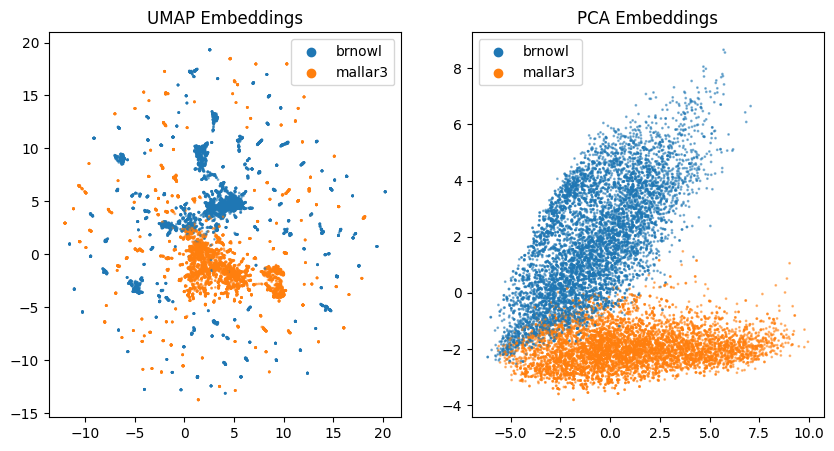

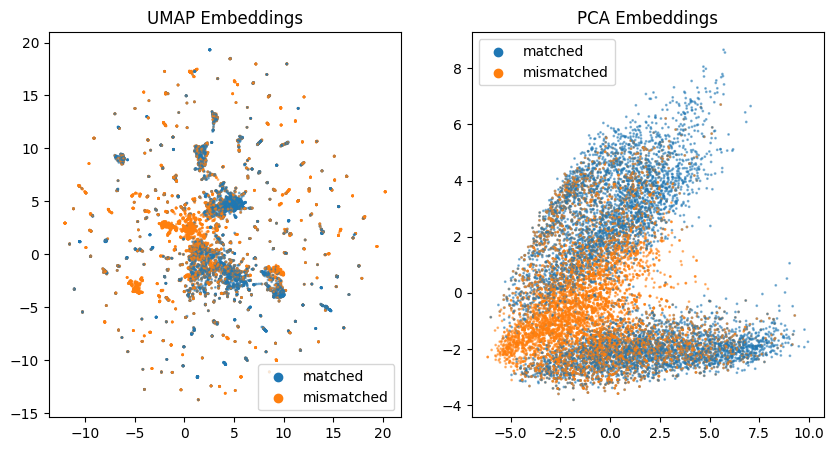

In [7]:
# plot the embeddings
primary_label = subset.select("primary_label").toPandas().primary_label
birdnet_label = subset.select("birdnet_label").toPandas().birdnet_label

embs = {"UMAP": emb_umap, "PCA": emb_pca}

# 2x1 plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
color_map = {color: f"C{i}" for i, color in enumerate(primary_label.unique())}

for i, (name, emb) in enumerate(embs.items()):
    ax = axes[i]
    ax.scatter(
        emb[:, 0], emb[:, 1], s=1, alpha=0.5, c=primary_label.apply(color_map.get)
    )
    ax.set_title(f"{name} Embeddings")
    # labels for the colors
    for label, color in color_map.items():
        ax.scatter([], [], c=color, label=label)
    ax.legend()
plt.show()


# 2x1 plot, but labeling whether the primary and birdnet labels match
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
color_map = {True: "C0", False: "C1"}
for i, (name, emb) in enumerate(embs.items()):
    ax = axes[i]
    ax.scatter(
        emb[:, 0],
        emb[:, 1],
        s=1,
        alpha=0.5,
        c=primary_label.eq(birdnet_label).apply(color_map.get),
    )
    ax.set_title(f"{name} Embeddings")
    # labels for the colors
    for label, color in color_map.items():
        ax.scatter([], [], c=color, label="matched" if label else "mismatched")
    ax.legend()

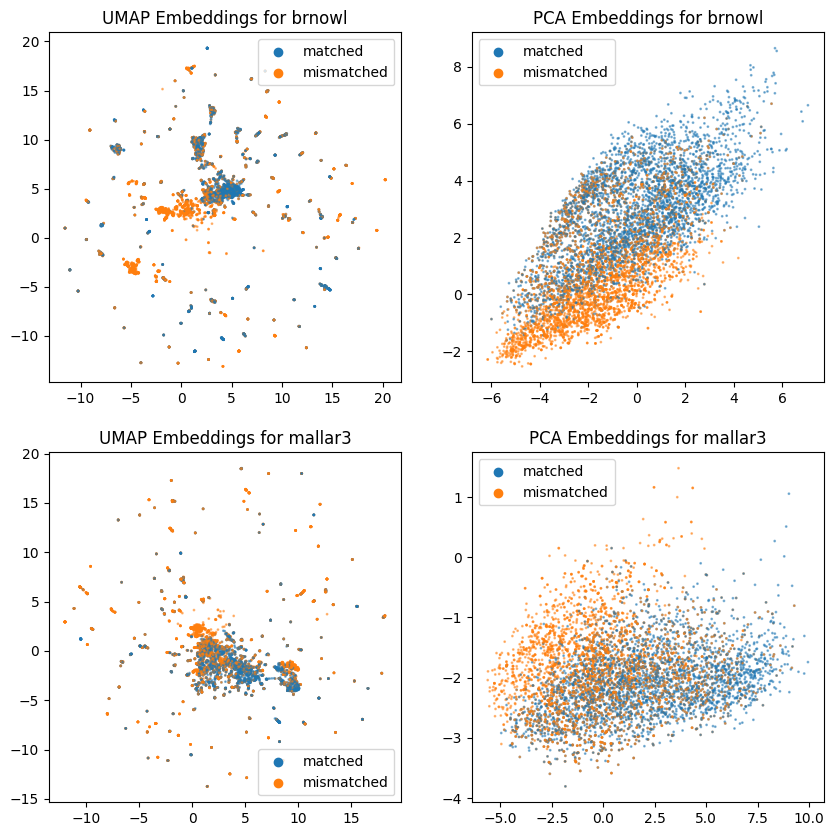

In [8]:
# check for each species if they are mislabeled or not
primary_label = subset.select("primary_label").toPandas().primary_label
birdnet_label = subset.select("birdnet_label").toPandas().birdnet_label

# 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
embs = {"UMAP": emb_umap, "PCA": emb_pca}
for i, species in enumerate(subset_species):
    mask = primary_label == species
    X_species = X[mask]
    y_species = primary_label.eq(birdnet_label)[mask]
    color_map = {True: "C0", False: "C1"}
    for j, (name, emb) in enumerate(embs.items()):
        ax = axes[i, j]
        ax.scatter(
            emb[mask, 0], emb[mask, 1], s=1, alpha=0.5, c=y_species.apply(color_map.get)
        )
        # labels for the colors
        for label, color in color_map.items():
            ax.scatter([], [], c=color, label="matched" if label else "mismatched")
        ax.set_title(f"{name} Embeddings for {species}")
        ax.legend()
plt.show()

In [9]:
# can we make a linear classifier to separate the two species?
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, primary_label == "brnowl")
clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(f"Accuracy: {score:.2%}")

Accuracy: 99.29%


In [10]:
# accuracy if the y label is instead the primary and birdnet labels matching

X_train, X_test, y_train, y_test = train_test_split(X, primary_label == birdnet_label)
clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(f"Accuracy: {score:.2%}")

Accuracy: 71.65%


In [91]:
# lets train a neural network with some non-linearities
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, roc_auc_score


class Net(nn.Module):
    def __init__(self, input_dim=320, hidden_dim=64):
        super().__init__()
        # 3 layers, input, hidden, output
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = self.fc1(x)
        # x = self.fc2(x)
        x = torch.sigmoid(self.fc3(x))
        return x


# https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6
activations = {}


def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()

    return hook


net = Net(input_dim=X.shape[1])
net.fc1.register_forward_hook(get_activation("fc1"))
net.fc2.register_forward_hook(get_activation("fc2"))
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

X_train, X_test, y_train, y_test = train_test_split(X, primary_label == "brnowl")

for epoch in range(100 + 1):
    optimizer.zero_grad()
    outputs = net(torch.from_numpy(X_train).float())
    loss = criterion(outputs, torch.from_numpy(y_train.values.reshape(-1, 1)).float())
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 1:
        print(f"Epoch: {epoch}, Loss: {loss.item():.2f}")

# get train emb
train_emb = activations["fc2"].numpy()

# check accuracy
predicted = net(torch.from_numpy(X_test).float())
test_emb = activations["fc2"].numpy()

accuracy_score(predicted.detach().numpy().reshape(-1) > 0.5, y_test)

Epoch: 0, Loss: 0.69
Epoch: 10, Loss: 0.47
Epoch: 20, Loss: 0.21
Epoch: 30, Loss: 0.10
Epoch: 40, Loss: 0.07
Epoch: 50, Loss: 0.06
Epoch: 60, Loss: 0.05
Epoch: 70, Loss: 0.05
Epoch: 80, Loss: 0.04
Epoch: 90, Loss: 0.04
Epoch: 100, Loss: 0.03


0.9844348047971422

In [92]:
# also use the sceond to last layer to do classification
clf = LogisticRegression().fit(train_emb, y_train)
accuracy_score(clf.predict(test_emb), y_test)

0.9829038019903037

In [93]:
# forward again to get new activations on full dataset
net(torch.from_numpy(X).float())
fc1 = activations["fc1"].detach().numpy()
fc2 = activations["fc2"].detach().numpy()
fc2.shape

(15675, 64)

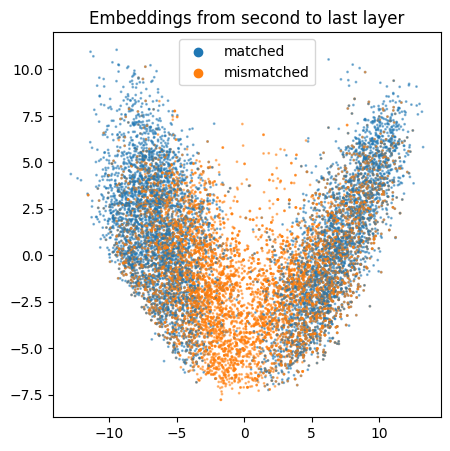

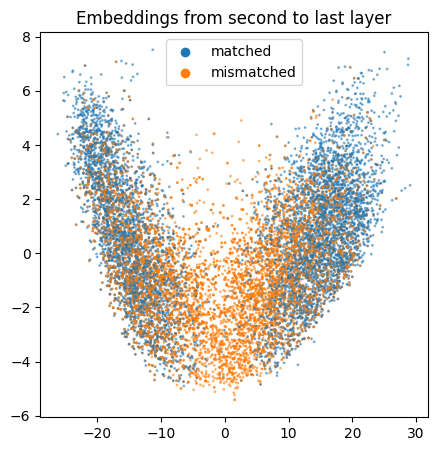

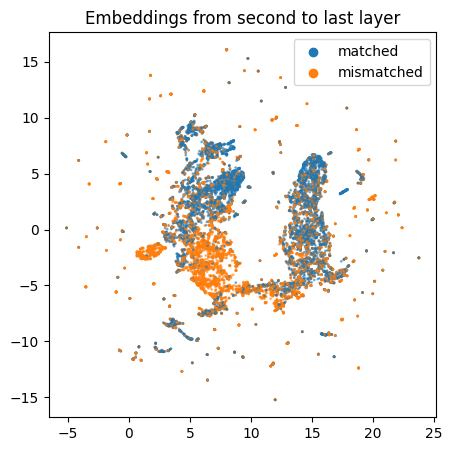

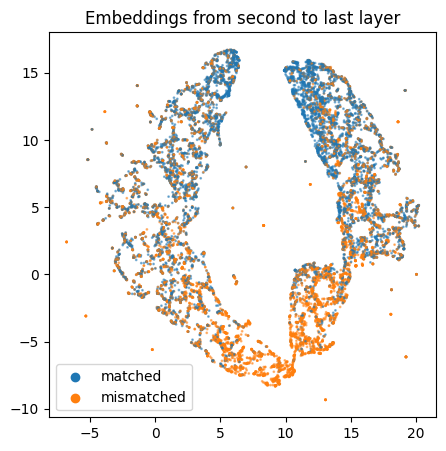

In [94]:
# lets plot the activation to see what it's doing


def plot_fc(emb, color, color_map):
    # plot the data
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(
        emb[:, 0],
        emb[:, 1],
        s=1,
        alpha=0.5,
        c=pd.Series(color).apply(color_map.get),
    )
    ax.set_title(f"Embeddings from second to last layer")
    # labels for the colors
    for label, color in color_map.items():
        ax.scatter([], [], c=color, label="matched" if label else "mismatched")
    ax.legend()
    plt.plot()


plot = lambda x: plot_fc(x, primary_label.eq(birdnet_label), {True: "C0", False: "C1"})

plot(PCA(n_components=2).fit_transform(fc1))
plot(PCA(n_components=2).fit_transform(fc2))
plot(UMAP(n_components=2).fit_transform(fc1))
plot(UMAP(n_components=2).fit_transform(fc2))